In [1]:
import os
import gc
from dotenv import load_dotenv
import copy
from tqdm import tqdm
import time
import torch 
import torch.nn as nn
from torch.optim import lr_scheduler, AdamW
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
import mlflow
import mlflow.pytorch
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd

#### Setting some constants

In [2]:
load_dotenv()
DATA_PATH = os.getenv('DATA_PATH')
RAW_PATH = os.getenv('RAW_PATH')
PROCESSED_PATH = os.getenv('PROCESSED_PATH')
MODEL_PATH = os.getenv('MODEL_PATH')

In [3]:
FOLDS = 5
BATCH_SIZE = 24
NUM_CLASSES = 1
NUM_EPOCHS = 3
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 1e-2
MAX_LEN = 256
MARGIN = 0.5
T_MAX = 500
MIN_LR = 1e-6
MODEL_NAME = 'FacebookAI/roberta-base'
CURRENT_MODEL_PATH = os.path.join(MODEL_PATH, 'roberta-base-freeze-with-accuracy')

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(CURRENT_MODEL_PATH, exist_ok=True)

In [5]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

#### Loading the data

In [6]:
df_train = pd.read_csv(os.path.join(PROCESSED_PATH, 'train_data.csv'))
df_train

,less_toxic,more_toxic
0,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...
2,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu..."
3,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...
4,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist"
...,...,...
15405,Straw poll being conducted on Catholic Church ...,"""\n\n Possible Troll \n\nWhy is the word """"MON..."
15406,Outrageous!!!!! \n\nThis block is outrageous ...,Bloody bots get more annoying every day.... He...
15407,Blink 182\n\nYou ahve 3 Blink 182 CD's???? WOW...,Homosexuality\nPlease attempt to refrain from ...
15408,I'm sorry. I'm not an admin. I will give you t...,get out my large penis


#### Considering that our data does not have target values, we will use KFold for cross-validation
Also we wont preprocess the data, since we are using a BERT-like models

In [7]:
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

for fold, (_, valid_idx) in enumerate(kf.split(df_train)):
    df_train.loc[valid_idx, 'kfold'] = fold

df_train["kfold"] = df_train["kfold"].astype(int)
df_train.head()

,less_toxic,more_toxic,kfold
0,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...,0
1,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...,4
2,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu...",3
3,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...,0
4,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist",4


#### Classes for the dataset and the model

In [8]:
class JigsawDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.more_toxic = df['more_toxic'].values
        self.less_toxic = df['less_toxic'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        more_toxic = self.more_toxic[index]
        less_toxic = self.less_toxic[index]
        inputs_more_toxic = self.tokenizer.encode_plus(
                                more_toxic,
                                truncation=True,
                                add_special_tokens=True,
                                max_length=self.max_len,
                                padding='max_length'
                            )
        inputs_less_toxic = self.tokenizer.encode_plus(
                                less_toxic,
                                truncation=True,
                                add_special_tokens=True,
                                max_length=self.max_len,
                                padding='max_length'
                            )
        target = 1
        
        more_toxic_ids = inputs_more_toxic['input_ids']
        more_toxic_mask = inputs_more_toxic['attention_mask']
        
        less_toxic_ids = inputs_less_toxic['input_ids']
        less_toxic_mask = inputs_less_toxic['attention_mask']
        
        
        return {
            'more_toxic_ids': torch.tensor(more_toxic_ids, dtype=torch.long),
            'more_toxic_mask': torch.tensor(more_toxic_mask, dtype=torch.long),
            'less_toxic_ids': torch.tensor(less_toxic_ids, dtype=torch.long),
            'less_toxic_mask': torch.tensor(less_toxic_mask, dtype=torch.long),
            'target': torch.tensor(target, dtype=torch.long)
        }

In [9]:
class JigsawModel(nn.Module):
    def __init__(self, model_name):
        super(JigsawModel, self).__init__()
        self.model = AutoModel.from_pretrained(model_name, return_dict=False)
        self.drop = nn.Dropout(p=0.2)
        self.fc = nn.Linear(768, NUM_CLASSES)
        
    def forward(self, ids, mask):        
        _, out = self.model(input_ids=ids,attention_mask=mask)
        out = self.drop(out)
        outputs = self.fc(out)
        return outputs

#### We will use MarginalRankingLoss as our loss function, since it will allow us to train the model with our pairs of sentences

In [10]:
def criterion(outputs1, outputs2, targets):
    return nn.MarginRankingLoss(margin=MARGIN)(outputs1, outputs2, targets)

In [11]:
def calculate_accuracy(less_toxic_outputs, more_toxic_outputs):
    '''
    Calculate accuracy of the model
    Idea is to check if our less toxic output is less than more toxic output
    '''
    less_toxic_outputs = less_toxic_outputs.cpu().detach().numpy()
    more_toxic_outputs = more_toxic_outputs.cpu().detach().numpy()
    return np.sum(less_toxic_outputs < more_toxic_outputs) / len(less_toxic_outputs)

#### Defining functions for training and evaluating the model

In [12]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    running_acc = 0.0

    loop = tqdm(dataloader)
    for data in loop:
        more_toxic_ids = data['more_toxic_ids'].to(device, dtype = torch.long)
        more_toxic_mask = data['more_toxic_mask'].to(device, dtype = torch.long)
        less_toxic_ids = data['less_toxic_ids'].to(device, dtype = torch.long)
        less_toxic_mask = data['less_toxic_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = more_toxic_ids.size(0)

        more_toxic_outputs = model(more_toxic_ids, more_toxic_mask)
        less_toxic_outputs = model(less_toxic_ids, less_toxic_mask)
        
        loss = criterion(more_toxic_outputs, less_toxic_outputs, targets.unsqueeze(1))
        loss.backward()
    
        optimizer.step()

        optimizer.zero_grad()

        if scheduler is not None:
            scheduler.step()
        
        acc = calculate_accuracy(less_toxic_outputs, more_toxic_outputs)

        running_acc += (acc * batch_size)
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        epoch_acc = running_acc / dataset_size

        loop.set_description(f'Epoch {epoch+1}/{NUM_EPOCHS}')
        loop.set_postfix(Train_Loss=epoch_loss, Train_Accuracy=epoch_acc,
                        LR=optimizer.param_groups[0]['lr'])
    
    return epoch_loss, epoch_acc

def eval_one_epoch(model, dataloader, device, epoch):
    model.eval()

    dataset_size = 0
    running_loss = 0.0
    running_acc = 0.0

    loop = tqdm(dataloader)

    with torch.no_grad():
        for data in loop:
            more_toxic_ids = data['more_toxic_ids'].to(device, dtype = torch.long)
            more_toxic_mask = data['more_toxic_mask'].to(device, dtype = torch.long)
            less_toxic_ids = data['less_toxic_ids'].to(device, dtype = torch.long)
            less_toxic_mask = data['less_toxic_mask'].to(device, dtype = torch.long)
            targets = data['target'].to(device, dtype=torch.long)

            batch_size = more_toxic_ids.size(0)

            more_toxic_outputs = model(more_toxic_ids, more_toxic_mask)
            less_toxic_outputs = model(less_toxic_ids, less_toxic_mask)

            loss = criterion(more_toxic_outputs, less_toxic_outputs, targets.unsqueeze(1))
            acc = calculate_accuracy(less_toxic_outputs, more_toxic_outputs)

            running_acc += (acc * batch_size)
            running_loss += (loss.item() * batch_size)
            dataset_size += batch_size

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_acc / dataset_size

            loop.set_description(f'Epoch {epoch+1}/{NUM_EPOCHS}')
            loop.set_postfix(Val_Loss=epoch_loss, Val_Accuracy=epoch_acc)

    return epoch_loss, epoch_acc

#### Functions to get scheduler and loaders

In [13]:
def fetch_scheduler(optimizer, scheduler=None):
    if scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=T_MAX, 
                                                   eta_min=MIN_LR)
    elif scheduler == 'LinearLR':
        scheduler = lr_scheduler.LinearLR(optimizer)

    elif scheduler == None:
        return None
    
    return scheduler

In [14]:
def prepare_loaders(fold, df, tokenizer, max_length, batch_size):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = JigsawDataset(df_train, tokenizer=tokenizer, max_length=max_length)
    valid_dataset = JigsawDataset(df_valid, tokenizer=tokenizer, max_length=max_length)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                              shuffle=True)
    

    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, 
                              shuffle=False)
    
    return train_loader, valid_loader

#### Function for main training loop

In [ ]:
from collections import defaultdict

def run_training(model, scheduler_name, device, num_epochs, fold, train_loader, valid_loader, freeze=False):
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = np.inf
    best_epoch_acc = 0.0

    history = defaultdict(list)
    
    for epoch in range(num_epochs): 
        if epoch == 0:
            if freeze:
                # Freeze the base model
                for param in model.model.parameters():
                    param.requires_grad = False
                    
                # Change lr
                optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=WEIGHT_DECAY)
                scheduler = fetch_scheduler(optimizer, scheduler_name)

        else:
            if freeze:
                # Unfreeze the base model
                for param in model.model.parameters():
                    param.requires_grad = True
                
                # Change lr
                optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
                scheduler = fetch_scheduler(optimizer, scheduler_name)


        train_epoch_loss, train_epoch_acc = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=device, epoch=epoch)
        
        val_epoch_loss, val_epoch_acc = eval_one_epoch(model, valid_loader, device=device, 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        
        # Log the metrics
        steps = (epoch+1) * len(train_loader)
        mlflow.log_metric("Train Loss", train_epoch_loss, step=steps)
        mlflow.log_metric("Valid Loss", val_epoch_loss, step=steps)
        mlflow.log_metric("Train Accuracy", train_epoch_acc, step=steps)
        mlflow.log_metric("Valid Accuracy", val_epoch_acc, step=steps)
        
        # Save the best model
        # if val_epoch_loss <= best_epoch_loss:
        #     print(f'Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})')
        #     best_epoch_loss = val_epoch_loss
        #     mlflow.log_metric("Best Loss", best_epoch_loss, step=steps)
        #     best_model_wts = copy.deepcopy(model.state_dict())
        #     PATH = os.path.join(CURRENT_MODEL_PATH, f'model_fold_{fold}.pth')
        #     torch.save(model.state_dict(), PATH)
        #     # Save a model file from the current directory
        #     print(f'Model Saved')

        if val_epoch_acc >= best_epoch_acc:
            print(f'Validation Accuracy Improved ({best_epoch_acc} ---> {val_epoch_acc})')
            best_epoch_acc = val_epoch_acc
            mlflow.log_metric("Best Accuracy", best_epoch_acc, step=steps)
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = os.path.join(CURRENT_MODEL_PATH, f'model_fold_{fold}.pth')
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f'Model Saved')
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    #print("Best Loss: {:.4f}".format(best_epoch_loss))
    print("Best Accuracy: {:.4f}".format(best_epoch_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [16]:
# Function to log the config
def mlflow_log_config():
    mlflow.log_param('FOLDS', FOLDS)
    mlflow.log_param('BATCH_SIZE', BATCH_SIZE)
    mlflow.log_param('NUM_CLASSES', NUM_CLASSES)
    mlflow.log_param('NUM_EPOCHS', NUM_EPOCHS)
    mlflow.log_param('LEARNING_RATE', LEARNING_RATE)
    mlflow.log_param('WEIGHT_DECAY', WEIGHT_DECAY)
    mlflow.log_param('MAX_LEN', MAX_LEN)
    mlflow.log_param('MARGIN', MARGIN)
    mlflow.log_param('T_MAX', T_MAX)
    mlflow.log_param('MIN_LR', MIN_LR)
    mlflow.log_param('MODEL_NAME', MODEL_NAME)

#### Training the model on folds

In [17]:
mlflow.set_experiment('Jigsaw-'+time.strftime("%Y-%m-%d-%H-%M-%S")+'-'+MODEL_NAME)
mlflow.end_run()

for fold in range(0, FOLDS):
    print(f'Training fold: {fold}')
    mlflow.start_run(run_name=f"Fold-{fold}")
    mlflow_log_config()
    
    # Create Dataloaders
    train_loader, valid_loader = prepare_loaders(fold=fold, df=df_train,
                                                 tokenizer=AutoTokenizer.from_pretrained(MODEL_NAME),
                                                 max_length=MAX_LEN, batch_size=BATCH_SIZE)
    model = JigsawModel(MODEL_NAME)
    model.to(DEVICE)
    print("Model Created")
    scheduler_name = 'CosineAnnealingLR'

    model, history = run_training(model, scheduler_name, DEVICE, NUM_EPOCHS, fold, train_loader, valid_loader, freeze=True)
    
    mlflow.end_run()
    
    del model, history, train_loader, valid_loader
    gc.collect()
    torch.cuda.empty_cache()

    print()

2025/03/24 19:57:41 INFO mlflow.tracking.fluent: Experiment with name 'Jigsaw-2025-03-24-19-57-41-FacebookAI/roberta-base' does not exist. Creating a new experiment.


Training fold: 0


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model Created


Epoch 1/3: 100%|██████████| 129/129 [00:20<00:00,  6.34it/s, Val_Accuracy=0.572, Val_Loss=0.493]


Validation Accuracy Improved (0.0 ---> 0.5717066839714471)
Model Saved



Epoch 2/3: 100%|██████████| 129/129 [00:21<00:00,  6.12it/s, Val_Accuracy=0.581, Val_Loss=0.437]


Validation Accuracy Improved (0.5717066839714471 ---> 0.5814406229720961)
Model Saved



Epoch 3/3: 100%|██████████| 129/129 [00:20<00:00,  6.22it/s, Val_Accuracy=0.573, Val_Loss=0.442]



Training complete in 0h 11m 1s
Best Accuracy: 0.5814

Training fold: 1


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model Created


Epoch 1/3: 100%|██████████| 129/129 [00:20<00:00,  6.31it/s, Val_Accuracy=0.555, Val_Loss=0.492]


Validation Accuracy Improved (0.0 ---> 0.554834523036989)
Model Saved



Epoch 2/3: 100%|██████████| 129/129 [00:20<00:00,  6.40it/s, Val_Accuracy=0.59, Val_Loss=0.431] 


Validation Accuracy Improved (0.554834523036989 ---> 0.5895522388059702)
Model Saved



Epoch 3/3: 100%|██████████| 129/129 [00:21<00:00,  6.02it/s, Val_Accuracy=0.588, Val_Loss=0.438]



Training complete in 0h 10m 36s
Best Accuracy: 0.5896

Training fold: 2


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model Created


Epoch 1/3: 100%|██████████| 129/129 [00:20<00:00,  6.29it/s, Val_Accuracy=0.532, Val_Loss=0.494]


Validation Accuracy Improved (0.0 ---> 0.5321219987021415)
Model Saved



Epoch 2/3: 100%|██████████| 129/129 [00:21<00:00,  6.08it/s, Val_Accuracy=0.586, Val_Loss=0.442]


Validation Accuracy Improved (0.5321219987021415 ---> 0.5863075924724205)
Model Saved



Epoch 3/3: 100%|██████████| 129/129 [00:22<00:00,  5.70it/s, Val_Accuracy=0.569, Val_Loss=0.452]



Training complete in 0h 11m 2s
Best Accuracy: 0.5863

Training fold: 3


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model Created


Epoch 1/3: 100%|██████████| 129/129 [00:21<00:00,  5.90it/s, Val_Accuracy=0.563, Val_Loss=0.493]


Validation Accuracy Improved (0.0 ---> 0.5629461388708631)
Model Saved



Epoch 2/3: 100%|██████████| 129/129 [00:21<00:00,  6.08it/s, Val_Accuracy=0.618, Val_Loss=0.422]


Validation Accuracy Improved (0.5629461388708631 ---> 0.6177806619078521)
Model Saved



Epoch 3/3: 100%|██████████| 129/129 [00:20<00:00,  6.16it/s, Val_Accuracy=0.615, Val_Loss=0.422]



Training complete in 0h 11m 4s
Best Accuracy: 0.6178

Training fold: 4


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model Created


Epoch 1/3: 100%|██████████| 129/129 [00:20<00:00,  6.23it/s, Val_Accuracy=0.575, Val_Loss=0.492]


Validation Accuracy Improved (0.0 ---> 0.5746268656716418)
Model Saved



Epoch 2/3: 100%|██████████| 129/129 [00:25<00:00,  5.15it/s, Val_Accuracy=0.606, Val_Loss=0.421]


Validation Accuracy Improved (0.5746268656716418 ---> 0.6064243997404283)
Model Saved



Epoch 3/3: 100%|██████████| 129/129 [00:23<00:00,  5.55it/s, Val_Accuracy=0.601, Val_Loss=0.425]



Training complete in 0h 11m 19s
Best Accuracy: 0.6064



#### Plots from mlflow

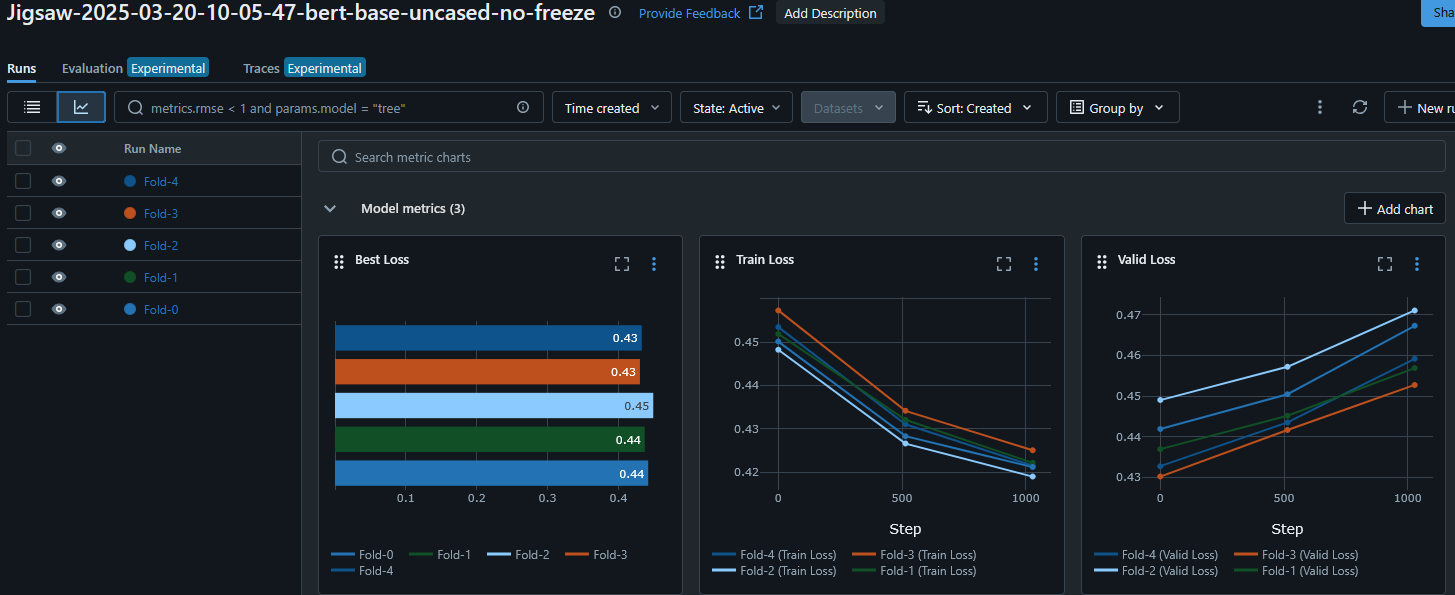

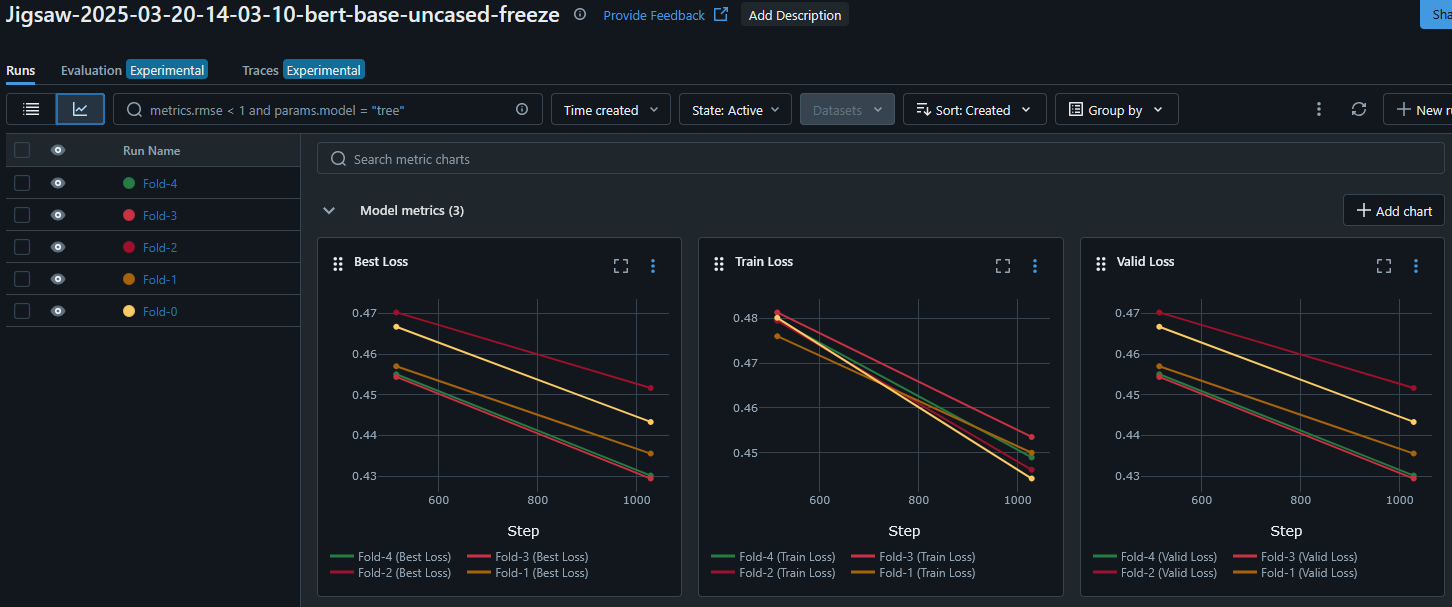

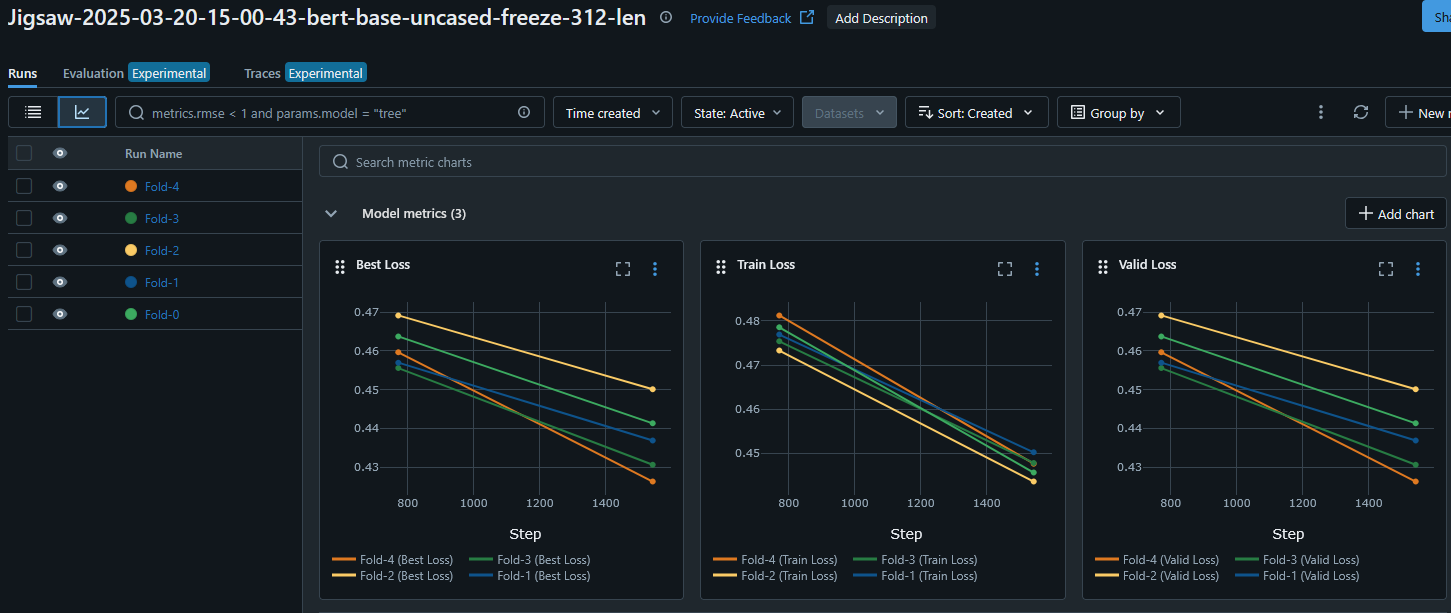

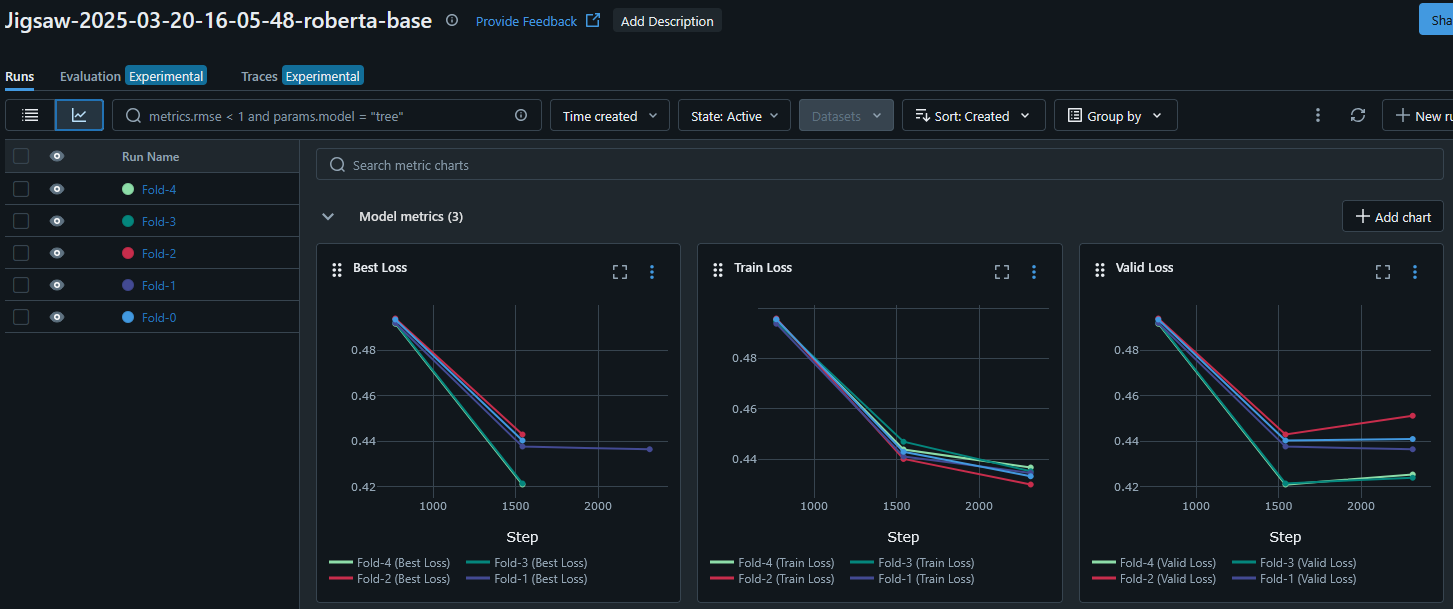

#### Submission results

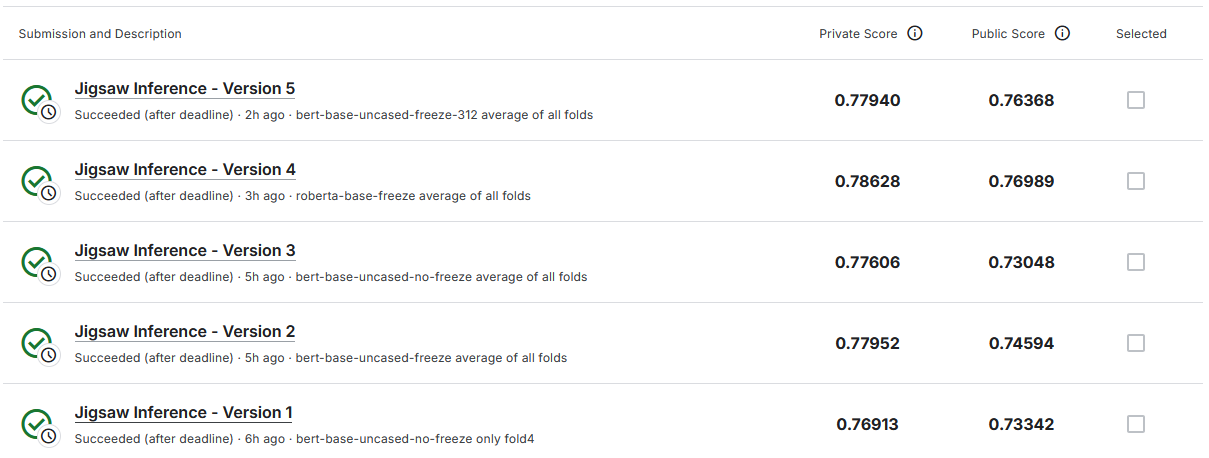

As we can see, we made 5 submissions.  
All of them except the 4th one were made with bert-base-uncased with some tweaks. 

The best bert-base-uncased model was the 2nd one, with a private score of 0.77952 and a public score of 0.74594. It used a a batch size of 24 and 2 epochs. 1st epoch was trained with a learning rate of 1e-3 and freezed bert base model. 2nd epoch was trained with a learning rate of 2e-5 and unfreezed bert base model.  

The best model overall was the 4th one - roberta-base, with a private score of 0.76989 and a public score of 0.78628. It used a batch size of 16 and 3 epochs. 1st epoch was trained with a learning rate of 1e-3 and freezed roberta base model. 2-3 epochs were trained with a learning rate of 2e-5 and unfreezed roberta base model.

Difference between public and private scores is quite big, but it is expected, since the public set is only about 5% of the whole dataset.

#### Conclusion
We chose the Jigsaw Rate Severity of Toxic Comments competition.  
We used a BERT-like models to solve the problem (bert-base-uncased and roberta-base).
We used MarginalRankingLoss as our loss function, since it will allow us to train the model with our pairs of sentences.  
We trained models on 5 folds and made 5 submissions.
The best model was the 4th one - roberta-base with freezing strategy. It achieved a private score of 0.76989 and a public score of 0.78628.

Possible improvements:
- Use more complex models/pretrained models on similar tasks
- Experiment with different hyperparameters
- Use more data for training
- Use some preprocessing techniques

Also, we retrained bert-base-uncased model and roberta-base model with addition of accuracy metric calculation.  
We got the following results on kaggle:  

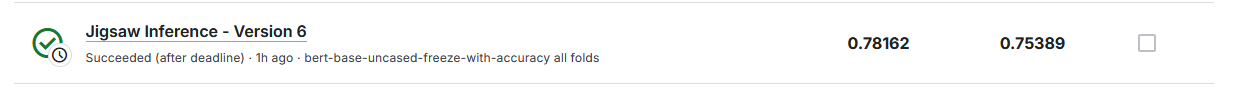  

and  

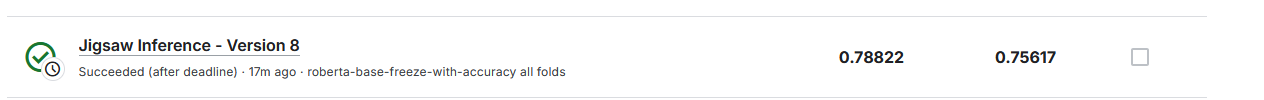  

Also, we got the following results on mlflow:  

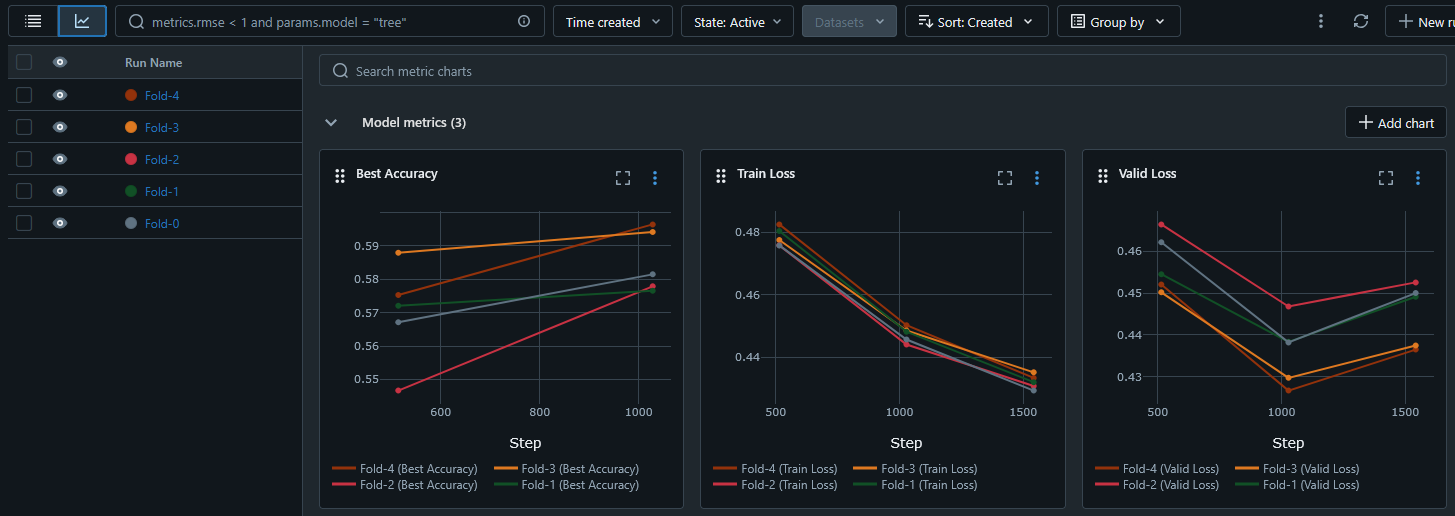  

and  

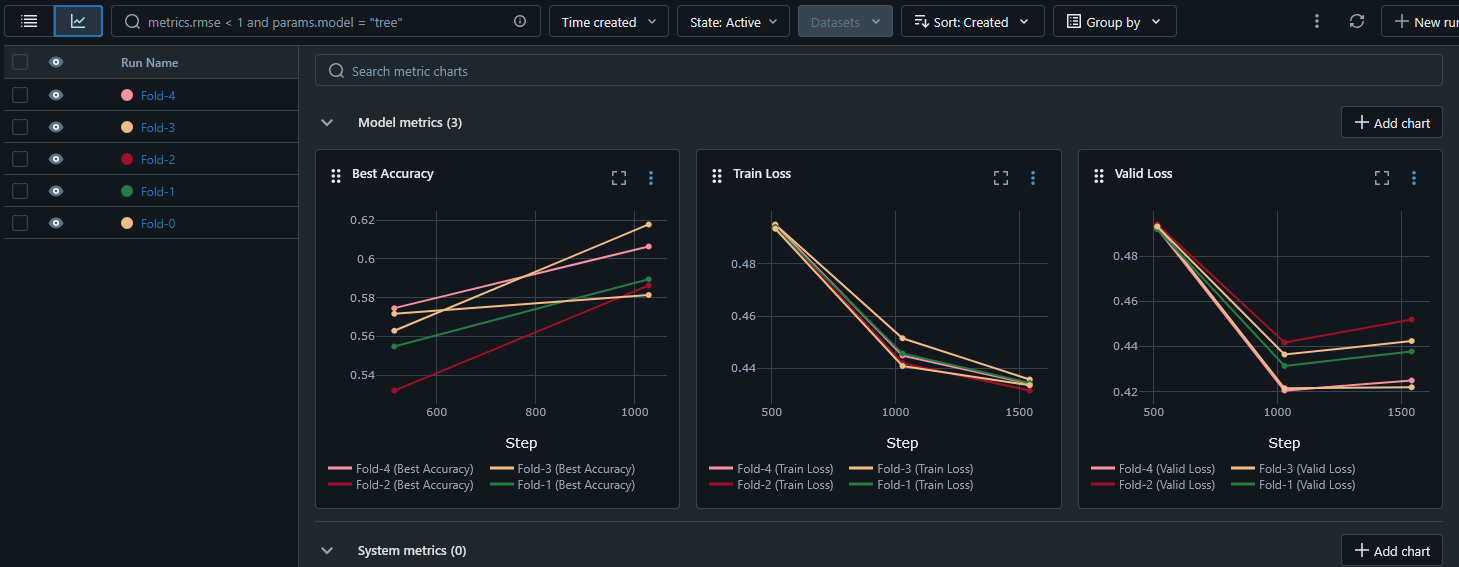  

Despite having quite big difference between our score and score on kaggle, we can see that it is consistent with our results on mlflow.  
So, if our local accuracy is high, we can expect a high score on kaggle.  
Also, we can see that accuracy correlates with our loss function, so we can also use it as a metric for our model.